In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
from spectral_connectivity import Multitaper, Connectivity
from spectral_decomposition import spectrum
import seaborn as sns

import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# ——— Parameters ——————————————————————————————————————————————————
fs        = 1000.0
durations = [0.1, 0.2, 0.5, 1.0]   # s
TW        = 2.0
K         = int(2*TW - 1)
n_iter    = 50
seeds     = np.arange(n_iter)
freqs_of_interest = [12, 30, 50, 80]  # Hz

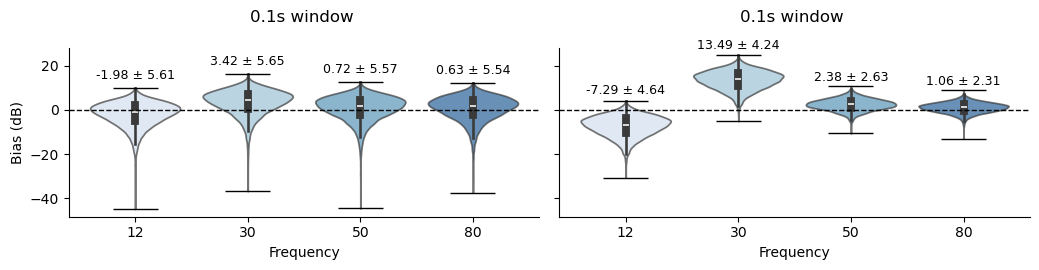

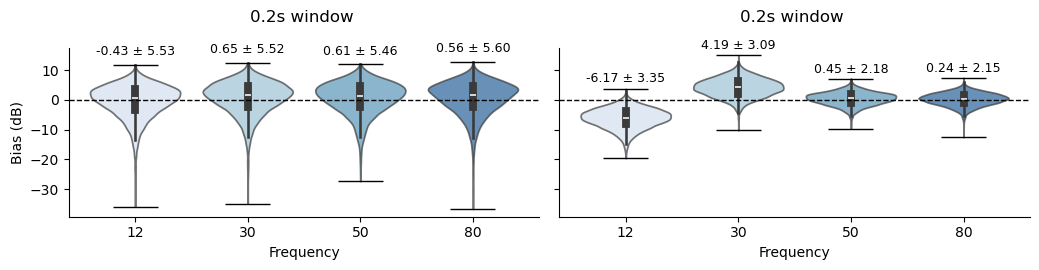

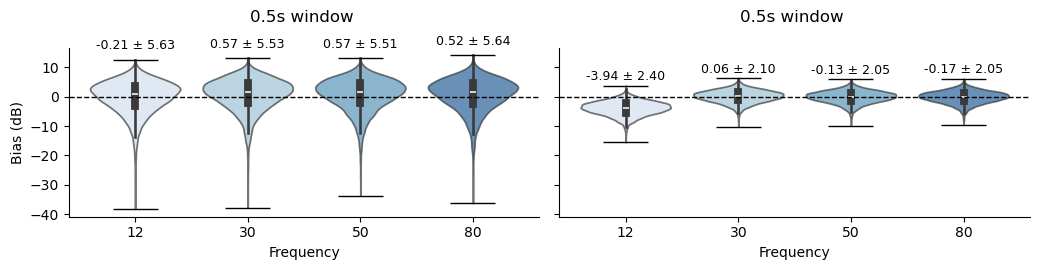

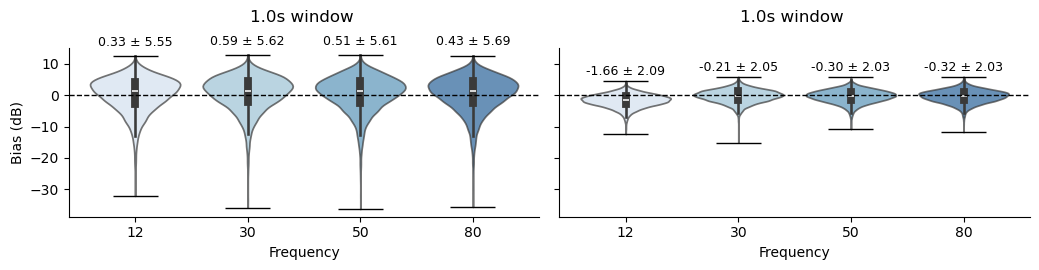

In [19]:
for duration in durations:
    # ——— empty‐signal freq grids ——————————————————————————————————
    N = int(fs * duration)
    f_hann, _ = periodogram(np.zeros(N), fs=fs, window='hann',   nfft=N, scaling='density')
    f_hamm, _ = periodogram(np.zeros(N), fs=fs, window='hamming', nfft=N, scaling='density')
    f_mt      = Connectivity.from_multitaper(
                   Multitaper(np.zeros(N), sampling_frequency=fs,
                             time_halfbandwidth_product=TW, n_tapers=K)
               ).frequencies
    # ——— find indices of interest ————————————————————————————————
    idx_hann = [np.argmin(np.abs(f_hann - f)) for f in freqs_of_interest]
    idx_hamm = [np.argmin(np.abs(f_hamm - f)) for f in freqs_of_interest]
    idx_mt   = [np.argmin(np.abs(f_mt   - f)) for f in freqs_of_interest]

    bias_hann_db = pd.read_csv(f'./data/bias_hann_db {duration}s.csv').to_numpy()
    bias_hamm_db = pd.read_csv(f'./data/bias_hamm_db {duration}s.csv').to_numpy()
    bias_mt_db = pd.read_csv(f'./data/bias_mt_db {duration}s.csv').to_numpy()

    # ——— plot violins with medians, means, and annotate mean±SD ——————
    fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
    for ax, data_db, fgrid, idxs, title in zip(
        axes,
        [bias_hann_db, bias_mt_db],
        [f_hann,       f_mt],
        [idx_hann,     idx_mt],
        ['Hann',       'Multitaper']
    ):
            # Convert data to long-form DataFrame
        df = pd.DataFrame({
            "Frequency": np.repeat(freqs_of_interest, data_db.shape[0]),
            "Bias": np.concatenate([data_db[:, j] for j in idxs])
        })

        sns.violinplot(
            data=df,
            x="Frequency",
            y="Bias",
            ax=ax,
            hue = "Frequency",
            palette = sns.color_palette("Blues", n_colors=len(freqs_of_interest)),
            legend=False,
            width=0.8,
            cut=0,
            alpha=0.7
        )

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        
        for i, freq in enumerate(df["Frequency"].unique()):
            group = df[df["Frequency"] == freq]["Bias"]
            ymin, ymax = group.min(), group.max()
            mean = group.mean()
            std = group.std()

            ax.set_title(f'{duration}s window \n ')
            
            # Draw top and bottom lines
            ax.hlines(ymax, i - 0.2, i + 0.2, colors='black', linewidth=1)
            ax.hlines(ymin, i - 0.2, i + 0.2, colors='black', linewidth=1)
            
            # Add mean ± std text above the top line
            ax.text(
                i, ymax + 0.05 * (ymax - ymin),  # Slightly above ymax
                f"{mean:.2f} ± {std:.2f}",
                ha='center', va='bottom', fontsize=9,
                color='black'
            )

        # ax.set_xticklabels([])
        # ax.set_xlabel('')    

        # vp = ax.violinplot(
        #     [data_db[:, j] for j in idxs],
        #     positions=freqs_of_interest,
        #     widths=0.5*(freqs_of_interest[1]-freqs_of_interest[0]),
        #     showmeans=True
        # )
        # ax.set_xscale('log')
        # ax.set_xticks(freqs_of_interest)
        # ax.set_xticklabels([str(f) for f in freqs_of_interest])
        # ax.axhline(0, linestyle='--', color='k', linewidth=1)
        # ax.set_title(f'{duration}s window \n ')
        # ax.set_xlabel('Frequency (Hz)')

        # # annotate mean±SD above each violin
        # means = [data_db[:, j].mean() for j in idxs]
        # stds  = [data_db[:, j].std()  for j in idxs]
        # ylim = ax.get_ylim()
        # y_text = min(
        #     max([data_db[:, j].max() for j in idxs]) + 0.05 * (ylim[1] - ylim[0]),
        #     ylim[1] - 0.03 * (ylim[1] - ylim[0])
        # )
        # for x, m, s in zip(freqs_of_interest, means, stds):
        #     ax.text(x, y_text, f'{m:.2f}±{s:.2f}', ha='center', fontsize=8)

    axes[0].set_ylabel('Bias (dB)')
    #plt.suptitle(f'Bias Distributions in dB at Selected Frequencies\n'
                 #f'(mean±SD shown, N={n_iter} runs)')
    plt.tight_layout(rect=[0,0,0.7,0.7])
    sns.despine()
    plt.show()